In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import PredictionErrorDisplay, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

data_path = './Dataset/'
data = pd.read_csv(data_path + 'hour.csv')

# EDA

In [43]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The following columns are instantly removed, because they either possess no ralationship to the data, like, 'instant', or will have very high correlation, in the example of 'casual' and 'registered' these data points if summed make up target variable.

In [44]:
to_drop = ['instant', 'dteday', 'casual', 'registered']

data = data.drop(to_drop, axis=1)

In [45]:
data.dtypes

season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [46]:
data.isnull().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [47]:
data.shape

(17379, 13)

In [48]:
data[data.duplicated()].shape[0]

2

In [49]:
data = data.drop_duplicates()

In [50]:
data.shape[0]

17377

## Visualizations

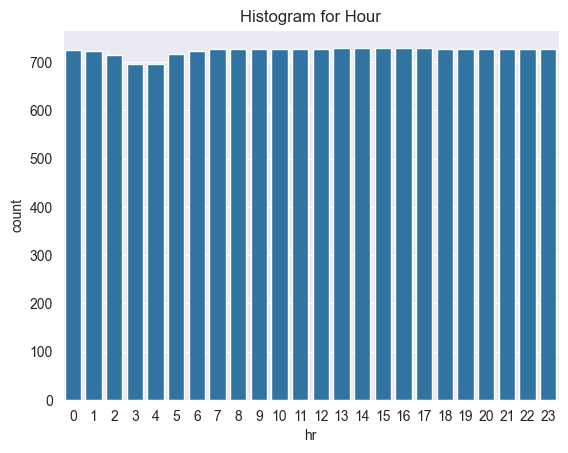

In [51]:
count_plot = sns.countplot(x='hr', data=data)
plt.title('Histogram for Hour')
fig = count_plot.get_figure()
fig.savefig("hr_countplot.png")

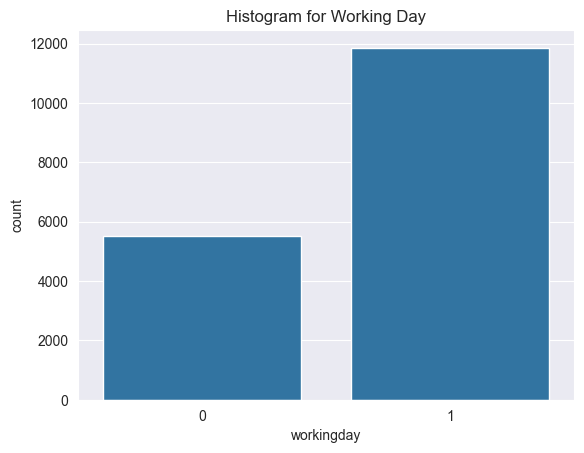

In [52]:
count_plot = sns.countplot(x='workingday', data=data)
plt.title('Histogram for Working Day')
fig = count_plot.get_figure()
fig.savefig("workingday_countplot.png")

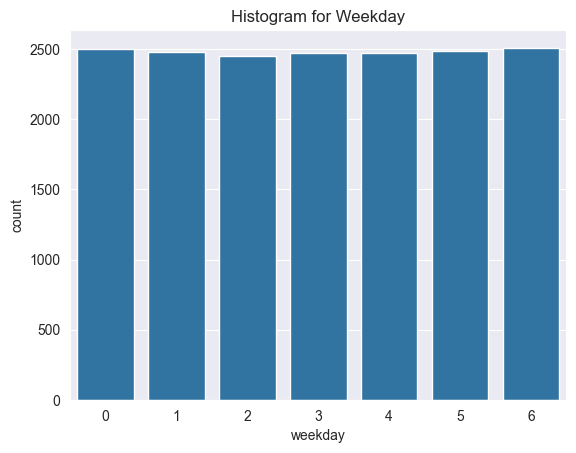

In [53]:
count_plot= sns.countplot(x='weekday', data=data)
plt.title('Histogram for Weekday')
fig = count_plot.get_figure()
fig.savefig("weekday_countplot.png")

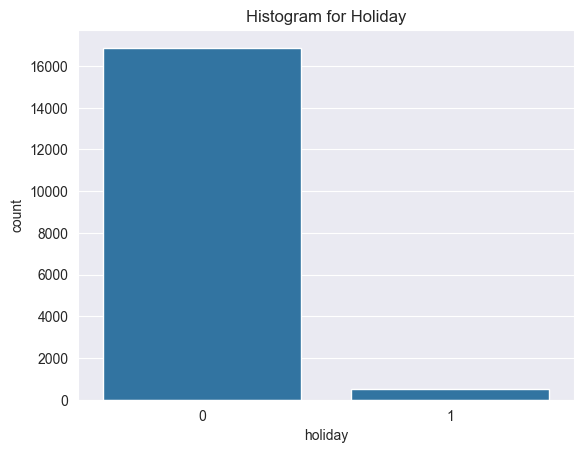

In [54]:
count_plot = sns.countplot(x='holiday', data=data)
plt.title('Histogram for Holiday')
fig = count_plot.get_figure()
fig.savefig("holiday_countplot.png")

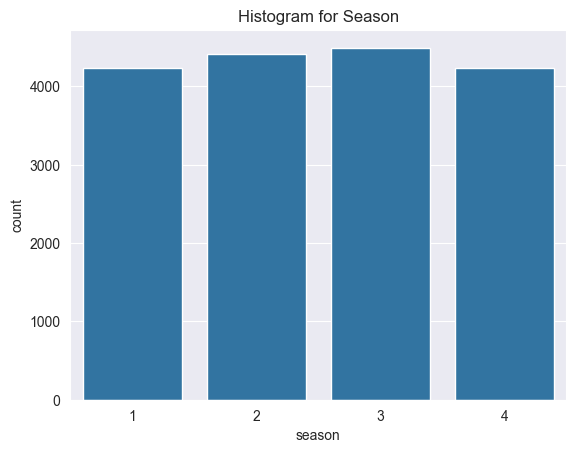

In [55]:
count_plot =sns.countplot(x='season', data=data)
plt.title('Histogram for Season')
fig = count_plot.get_figure()
fig.savefig("season_countplot.png")

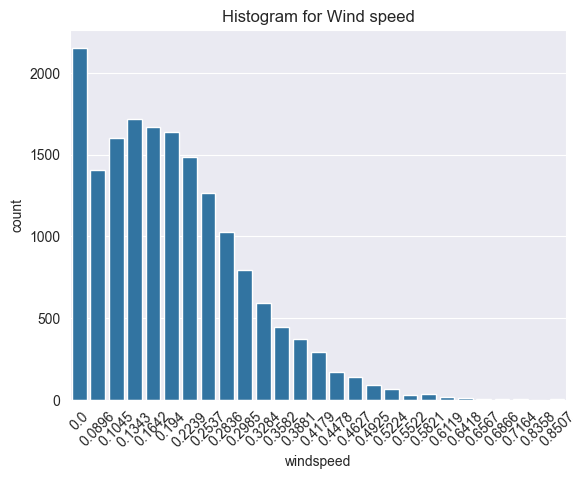

In [76]:
count_plot =sns.countplot(x='windspeed', data=data)
plt.title('Histogram for Wind speed')
plt.xticks(rotation=45)
fig = count_plot.get_figure()
fig.savefig("windspeed_countplot.png")

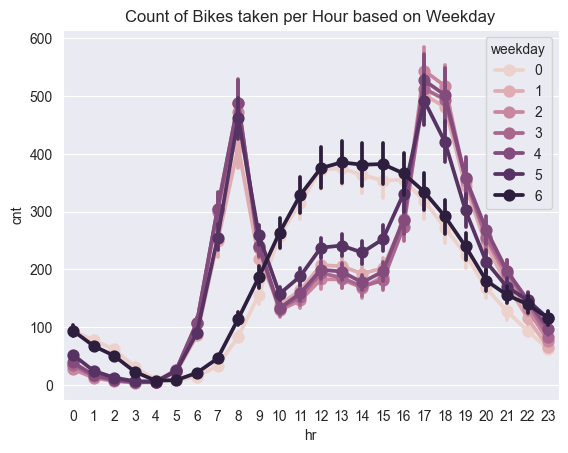

In [57]:
pointplot = sns.pointplot(x='hr', y='cnt', hue='weekday', data=data)
plt.title('Count of Bikes taken per Hour based on Weekday')
fig = pointplot.get_figure()
fig.savefig("hr_weekday_pointplot.png")

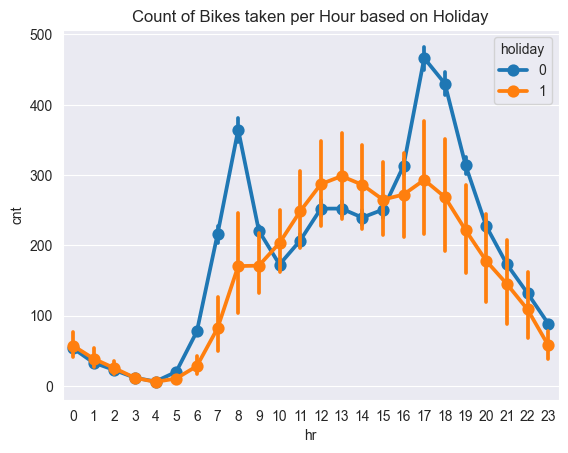

In [58]:
pointplot =sns.pointplot(x='hr', y='cnt', hue='holiday', data=data)
plt.title('Count of Bikes taken per Hour based on Holiday')
fig = pointplot.get_figure()
fig.savefig("hr_holiday_pointplot.png")

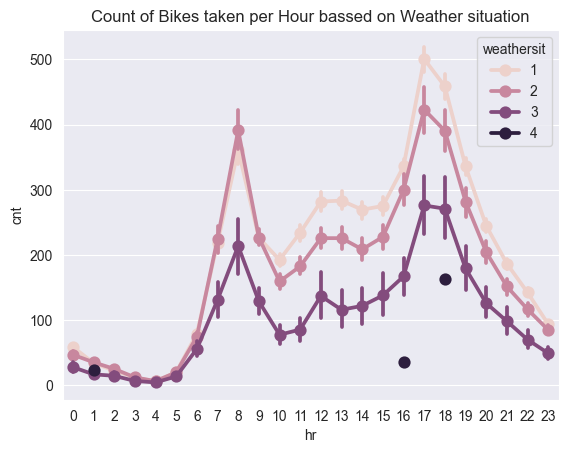

In [59]:
pointplot = sns.pointplot(x='hr', y='cnt', hue='weathersit', data=data)
plt.title('Count of Bikes taken per Hour bassed on Weather situation')
fig = pointplot.get_figure()
fig.savefig("hr_weathersit_pointplot.png")

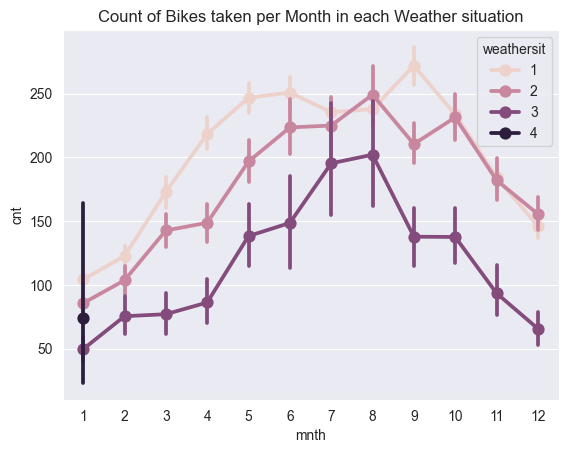

In [60]:
pointplot = sns.pointplot(y='cnt', x='mnth', hue='weathersit', data=data)
plt.title('Count of Bikes taken per Month in each Weather situation')
fig = pointplot.get_figure()
fig.savefig("mnth_weathersit_pointplot.png")

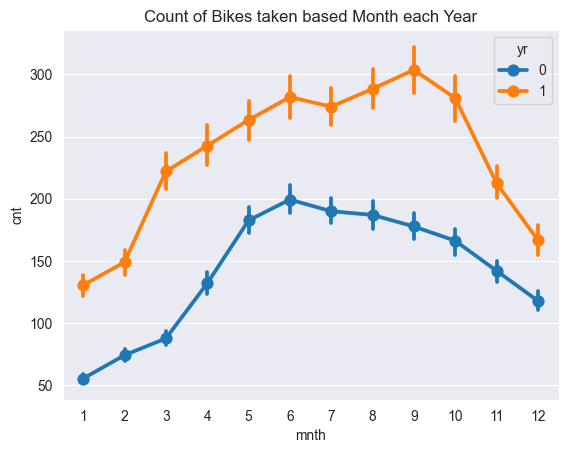

In [61]:
pointplot = sns.pointplot(x='mnth', y='cnt', hue='yr', data=data)
plt.title('Count of Bikes taken based Month each Year')
fig = pointplot.get_figure()
fig.savefig("mnth_yr_pointplot.png")

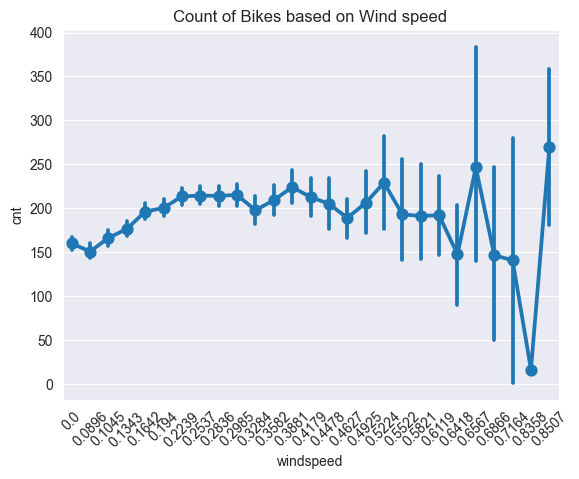

In [75]:
pointplot = sns.pointplot(x='windspeed', y='cnt', data=data)
plt.title('Count of Bikes based on Wind speed')
plt.xticks(rotation=45)
fig = pointplot.get_figure()
fig.savefig("windspeed_pointplot.png")

## Variable Boxplots

In [63]:
float_features = ['temp', 'hum', 'windspeed', 'atemp']

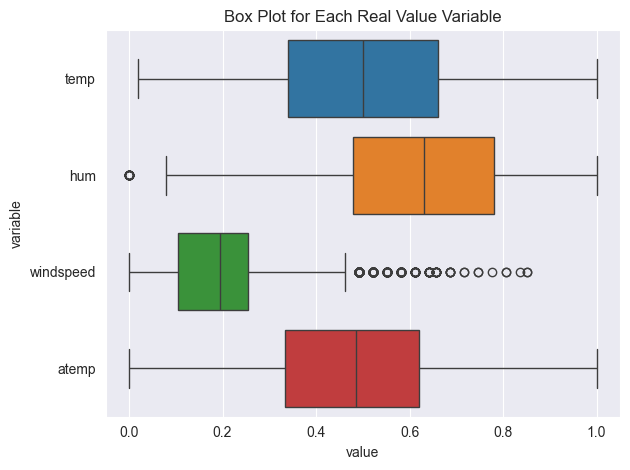

In [64]:
data_long = data.loc[:,float_features].melt()
ax = sns.boxplot(data=data_long, x="value", y="variable", orient="h", hue="variable")
plt.title('Box Plot for Each Real Value Variable')
plt.tight_layout()
plt.savefig("boxplot.png")
plt.show()

In [65]:
print(f"Percentage of humidity data outliers: {data[data['hum'] <0.08].shape[0]/data.shape[0] * 100:.3f}%")
print(f"Percentage of humidity data outliers: {data[data['windspeed'] >=0.5].shape[0]/data.shape[0] * 100:.4f}%")

Percentage of humidity data outliers: 0.127%
Percentage of humidity data outliers: 1.3236%


In [66]:
def remove_outliers(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr

    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(data[column] >= upper)[0]
    lower_array = np.where(data[column] <= lower)[0]

    print(f'Old shape with {column}: {data.shape[0]}')

    # Removing the outliers
    data =data.drop(index=upper_array, inplace=False)
    data = data.drop(index=lower_array, inplace=False)

    # Print the new shape of the DataFrame
    print(f'New shape with {column}: {data.shape[0]}')

    return data

data = remove_outliers(data, 'hum')
data = remove_outliers(data, 'windspeed')

Old shape with hum: 17377
New shape with hum: 17355
Old shape with windspeed: 17355
New shape with windspeed: 17014


## Correlation matrix

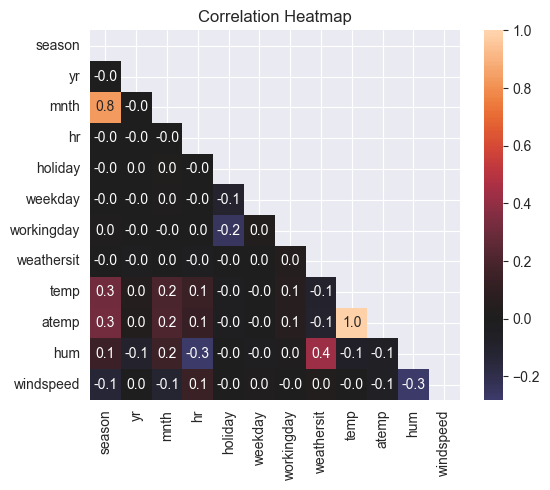

In [80]:
corr = data.loc[:,data.columns!='cnt'].corr(method="pearson")
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

heatmap = sns.heatmap(
    corr,
    mask = mask,
    vmax=1,
    center=0,
    annot=True,
    fmt='.1f',
    square=True,
)
plt.title('Correlation Heatmap')
fig = heatmap.get_figure()
fig.savefig("heatmap.png", bbox_inches='tight')

In [68]:
corr_matrix = round(data.corr(),2)
print(np.abs(corr_matrix['cnt']).sort_values(ascending=False))

cnt           1.00
temp          0.40
atemp         0.40
hr            0.40
hum           0.33
yr            0.25
season        0.18
weathersit    0.14
mnth          0.12
windspeed     0.10
holiday       0.03
weekday       0.03
workingday    0.03
Name: cnt, dtype: float64


<Figure size 10000x10000 with 0 Axes>

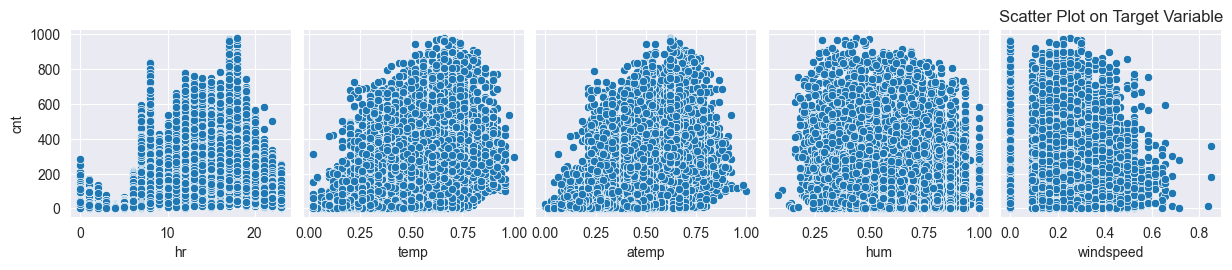

In [82]:
plt.figure(figsize=(100, 100))
sns.pairplot(data, x_vars=['hr','temp','atemp', 'hum','windspeed'], y_vars='cnt')
plt.title('Scatter Plot on Target Variable')
plt.savefig("pairplot.png", bbox_inches='tight')
plt.show()

From correlation matrix it can be seen that there are dependent variables, which should be removed, like
temp and atemp


In [1211]:
print(np.corrcoef(data['season'], data['cnt']))

print(np.corrcoef(data['mnth'], data['cnt']))

print(np.corrcoef(data['windspeed'], data['cnt']))

[[1.         0.17644408]
 [0.17644408 1.        ]]
[[1.         0.12005783]
 [0.12005783 1.        ]]
[[1.         0.10166131]
 [0.10166131 1.        ]]


In [1212]:
def one_hot_encoder(df,column):
    df = pd.concat([df,pd.get_dummies(df[column],prefix=column, dtype=int)],axis=1)
    df = df.drop(columns = [column],axis=1)
    return df

ohe_columns = ['hr', 'mnth', 'holiday', 'season', 'weekday', 'workingday', 'weathersit']

for col in ohe_columns:
    data[col] = data[col].astype('category')


for col in ohe_columns:
    data = one_hot_encoder(data,col)

In [1213]:
data.head()

,yr,temp,atemp,hum,windspeed,cnt,hr_0,hr_1,hr_2,hr_3,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0.24,0.2879,0.81,0.0,16,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
1,0,0.22,0.2727,0.80,0.0,40,0,1,0,0,...,0,0,0,1,1,0,1,0,0,0
2,0,0.22,0.2727,0.80,0.0,32,0,0,1,0,...,0,0,0,1,1,0,1,0,0,0
3,0,0.24,0.2879,0.75,0.0,13,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
4,0,0.24,0.2879,0.75,0.0,1,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0


# Model Training

In [1214]:
### Custom format MSE
def rmse(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.sqrt(np.mean((y-y_pred)**2))

def rmse(y, y_pred):
    return np.sqrt(np.mean((y-y_pred)**2))

In [1215]:
y = data.pop('cnt')

X = data.drop(columns=['temp'],axis=1)

In [1216]:
X.shape

(17014, 59)

In [1217]:
X.columns

Index(['yr', 'atemp', 'hum', 'windspeed', 'hr_0', 'hr_1', 'hr_2', 'hr_3',
       'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11',
       'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19',
       'hr_20', 'hr_21', 'hr_22', 'hr_23', 'mnth_1', 'mnth_2', 'mnth_3',
       'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10',
       'mnth_11', 'mnth_12', 'holiday_0', 'holiday_1', 'season_1', 'season_2',
       'season_3', 'season_4', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'workingday_0',
       'workingday_1', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4'],
      dtype='object')

In [1218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

In [1167]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [1168]:
rmse_score_lr = rmse(y_test, y_pred)

print(f'Root mean squared error score: {rmse_score_lr:.3f}')

Root mean squared error score: 102.283


In [1169]:
r2_score_lr = r2_score(y_test, y_pred)

print(f'R2 score: {r2_score_lr:.3f}')

R2 score: 0.678


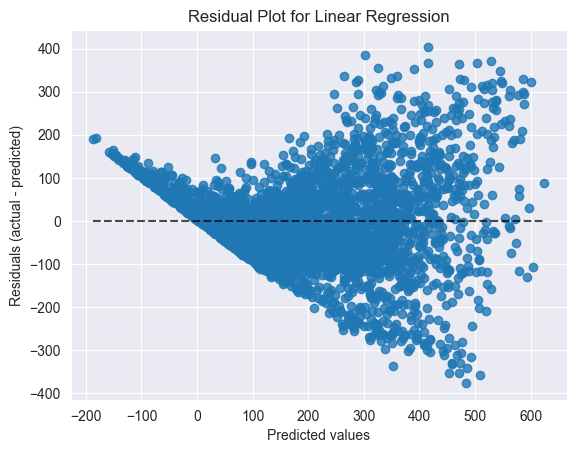

In [1170]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()
plt.title("Residual Plot for Linear Regression")
plt.savefig("residual_plot_lr.png")
plt.show()

In [1171]:
zipp = zip(X.columns, np.round(np.abs(lr.coef_),2))
zipp_df = pd.DataFrame(zipp)

zipp_df.sort_values(by=1, ascending=False).head(10)

,0,1
57,weathersit_3,6.056743e+14
56,weathersit_2,6.056743e+14
58,weathersit_4,6.056743e+14
55,weathersit_1,6.056743e+14
38,mnth_11,5.100349e+14
39,mnth_12,5.100349e+14
34,mnth_7,5.100349e+14
28,mnth_1,5.100349e+14
29,mnth_2,5.100349e+14
31,mnth_4,5.100349e+14


### Applying Standardization to columns with real data values

In [1172]:
scaler = StandardScaler()

X_train_scaled = X_train.copy(deep=True)
X_test_scaled = X_test.copy(deep=True)

X_train_scaled['atemp'] = scaler.fit_transform(np.asarray(X_train['atemp']).reshape(-1, 1))
X_test_scaled['atemp'] = scaler.fit_transform(np.asarray(X_test['atemp']).reshape(-1, 1))

X_train_scaled['hum'] = scaler.fit_transform(np.asarray(X_train['hum']).reshape(-1, 1))
X_test_scaled['hum'] = scaler.fit_transform(np.asarray(X_test['hum']).reshape(-1, 1))

In [1173]:
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

In [1174]:
rmse_score_lr_scaled = rmse(y_test, y_pred)

print(f'Root mean squared error score: {rmse_score_lr_scaled:.3f}')

Root mean squared error score: 102.293


In [1175]:
r2_score_lr_scaled = r2_score(y_test, y_pred)

print(f'R2 score: {r2_score_lr_scaled:.3f}')

R2 score: 0.677


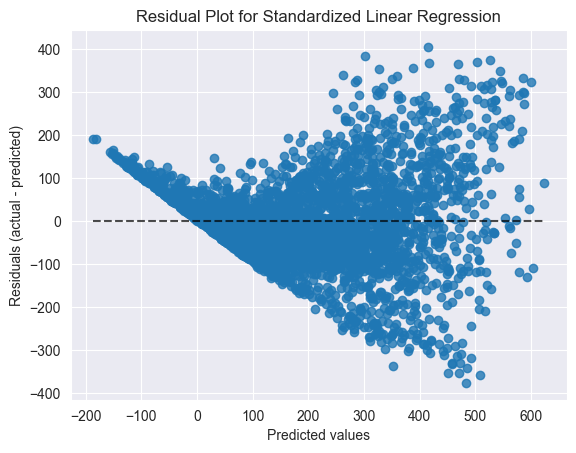

In [1176]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()
plt.title("Residual Plot for Standardized Linear Regression")
plt.savefig("residual_plot_std_lr.png")
plt.show()

In [1177]:
zipp = zip(X.columns, np.round(np.abs(lr.coef_),2))
zipp_df = pd.DataFrame(zipp)

zipp_df.sort_values(by=1, ascending=False).head(10)

,0,1
54,workingday_1,1.001139e+15
42,season_1,5.990332e+14
44,season_3,5.990332e+14
43,season_2,5.990332e+14
45,season_4,5.990332e+14
53,workingday_0,5.349583e+14
40,holiday_0,5.053795e+14
46,weekday_0,3.170713e+14
52,weekday_6,3.170713e+14
55,weathersit_1,3.021137e+14


### Regularization

In [1178]:
parameters = {'alpha': np.logspace(-2, 1, base=10)}

lasso_grid = GridSearchCV(Lasso(), parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, refit=True)
lasso_grid.fit(X_train, y_train)

print(f'Best regularization parameter for Lasso was {lasso_grid.best_params_['alpha']:.4f} with RMSE score {np.sqrt(np.abs(lasso_grid.best_score_)):.4f}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best regularization parameter for Lasso was 0.0153 with RMSE score 102.0398


In [1179]:
lasso_regr = Lasso(**lasso_grid.best_params_)
lasso_regr.fit(X_train, y_train)
y_pred = lasso_regr.predict(X_test)

In [1180]:
rmse_score_lasso = rmse(y_test, y_pred)

print(f'Root mean squared error score: {rmse_score_lasso:.3f}')

Root mean squared error score: 102.261


In [1181]:
r2_score_lasso = r2_score(y_test, y_pred)

print(f'R2 score: {r2_score_lasso:.3f}')

R2 score: 0.678


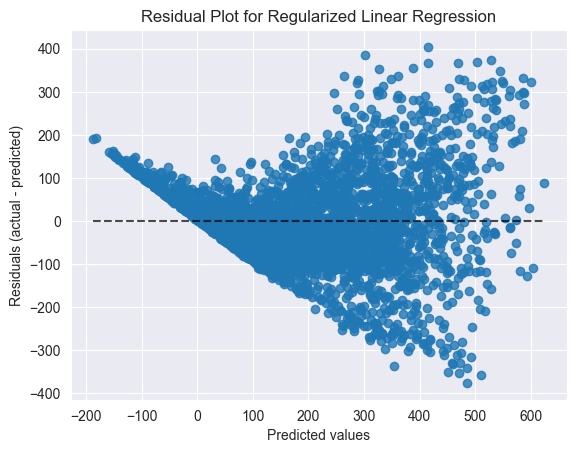

In [1182]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()
plt.title("Residual Plot for Regularized Linear Regression")
plt.savefig("residual_plot_rlr.png")
plt.show()

In [1183]:
zipp = zip(X.columns, np.round(np.abs(lasso_regr.coef_),2))
zipp_df = pd.DataFrame(zipp)

zipp_df.sort_values(by=1, ascending=False).head(10)

,0,1
1,atemp,242.72
21,hr_17,228.84
8,hr_4,195.81
7,hr_3,193.61
22,hr_18,191.43
6,hr_2,182.69
9,hr_5,179.77
5,hr_1,169.81
12,hr_8,165.83
4,hr_0,156.05


## SVM

In [1115]:
# svm = SVC()
# 
# parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.1, 0.01, 0.001, 1.0]}
# 
# svc_grid_search = GridSearchCV(svm, parameters, cv=5, scoring='neg_mean_squared_error', verbose=1, refit=True)
# svc_grid_search.fit(X_train, y_train)
# 
# print(f'Best parameters were: {svc_grid_search.best_params_} with score: {svc_grid_search.best_score_}')

Best parameters were: {'C': 1.0, 'kernel': 'linear'} with score: 99.390 \
No real improvement, compared to using default values for SVM

In [1116]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [1117]:
rmse_score_svm = rmse(y_test, y_pred)

print(f'Root mean squared error score: {rmse_score_svm:.3f}')

Root mean squared error score: 99.432


In [1118]:
r2_score_svm = r2_score(y_test, y_pred)

print(f'R2 score: {r2_score_svm:.3f}')

R2 score: 0.695


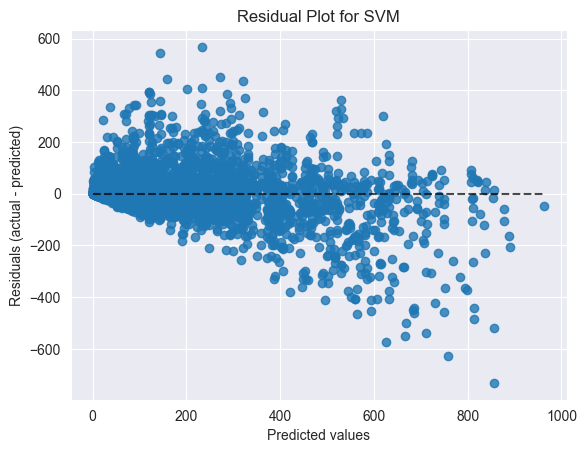

In [1119]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()
plt.title("Residual Plot for SVM")
plt.savefig("residual_plot_svm.png")
plt.show()

## Random Forest

In [1120]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [1121]:
rmse_score_rf = rmse(y_test, y_pred)

print(f'Root mean squared error score: {rmse_score_rf:.3f}')

Root mean squared error score: 47.818


In [1122]:
r2_score_rf = r2_score(y_test, y_pred)

print(f'R2 score: {r2_score_rf:.3f}')

R2 score: 0.930


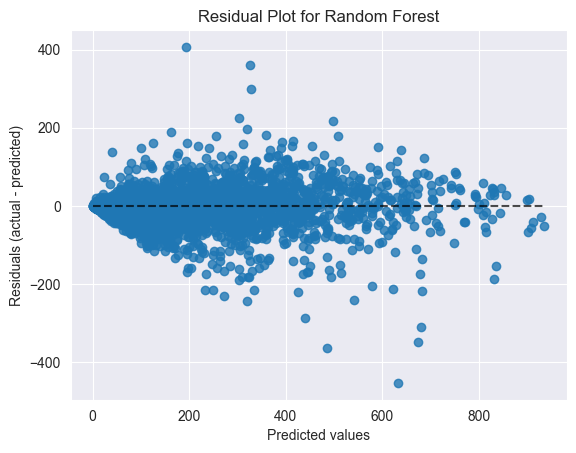

In [1123]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()
plt.title("Residual Plot for Random Forest")
plt.savefig("residual_plot_rf.png")
plt.show()

In [1124]:
zipp = zip(X.columns, np.round(np.abs(rf.feature_importances_),2))
zipp_df = pd.DataFrame(zipp)
zipp_df.sort_values(by=1, ascending=False).head(10)

,0,1
1,atemp,0.21
21,hr_17,0.09
0,yr,0.08
22,hr_18,0.08
2,hum,0.08
12,hr_8,0.06
54,workingday_1,0.05
53,workingday_0,0.05
23,hr_19,0.03
11,hr_7,0.02


## Neural Network

  0%|          | 1/250 [00:00<02:39,  1.56it/s]

Train Loss: 31805.6143, Val Loss: 7396.8203


  1%|          | 2/250 [00:01<02:16,  1.82it/s]

Train Loss: 6409.5735, Val Loss: 5562.7090


  1%|          | 3/250 [00:01<02:07,  1.93it/s]

Train Loss: 4971.3388, Val Loss: 4387.6753


  2%|▏         | 4/250 [00:02<02:00,  2.04it/s]

Train Loss: 4031.5614, Val Loss: 3624.5527


  2%|▏         | 5/250 [00:02<01:56,  2.10it/s]

Train Loss: 3421.2488, Val Loss: 3205.2612


  2%|▏         | 6/250 [00:02<01:54,  2.14it/s]

Train Loss: 3070.2698, Val Loss: 2941.9426


  3%|▎         | 7/250 [00:03<01:51,  2.18it/s]

Train Loss: 2813.6305, Val Loss: 2714.4915


  3%|▎         | 8/250 [00:03<01:49,  2.21it/s]

Train Loss: 2666.6339, Val Loss: 2631.1594


  4%|▎         | 9/250 [00:04<01:47,  2.23it/s]

Train Loss: 2536.8147, Val Loss: 2526.3279


  4%|▍         | 10/250 [00:04<01:46,  2.26it/s]

Train Loss: 2443.5704, Val Loss: 2441.4255


  4%|▍         | 11/250 [00:05<01:44,  2.29it/s]

Train Loss: 2397.7866, Val Loss: 2367.3892


  5%|▍         | 12/250 [00:05<01:43,  2.31it/s]

Train Loss: 2322.1355, Val Loss: 2370.0203


  5%|▌         | 13/250 [00:05<01:43,  2.29it/s]

Train Loss: 2273.9547, Val Loss: 2359.1841


  6%|▌         | 14/250 [00:06<01:43,  2.29it/s]

Train Loss: 2209.8687, Val Loss: 2313.3418


  6%|▌         | 15/250 [00:06<01:42,  2.29it/s]

Train Loss: 2166.2900, Val Loss: 2275.5725


  6%|▋         | 16/250 [00:07<01:43,  2.27it/s]

Train Loss: 2112.3309, Val Loss: 2258.3230


  7%|▋         | 17/250 [00:07<01:44,  2.23it/s]

Train Loss: 2082.3194, Val Loss: 2227.0195


  7%|▋         | 18/250 [00:08<01:44,  2.23it/s]

Train Loss: 2029.2261, Val Loss: 2144.8137


  8%|▊         | 19/250 [00:08<01:43,  2.23it/s]

Train Loss: 1987.3296, Val Loss: 2116.2344


  8%|▊         | 20/250 [00:09<01:42,  2.24it/s]

Train Loss: 1955.9460, Val Loss: 2098.7036


  8%|▊         | 21/250 [00:09<01:40,  2.28it/s]

Train Loss: 1906.9680, Val Loss: 2061.8601


  9%|▉         | 22/250 [00:09<01:40,  2.28it/s]

Train Loss: 1876.3776, Val Loss: 2056.5916


  9%|▉         | 23/250 [00:10<01:39,  2.28it/s]

Train Loss: 1832.0035, Val Loss: 2003.8457


 10%|▉         | 24/250 [00:10<01:38,  2.29it/s]

Train Loss: 1820.8531, Val Loss: 2007.4950


 10%|█         | 25/250 [00:11<01:41,  2.22it/s]

Train Loss: 1776.8042, Val Loss: 2002.8944


 10%|█         | 26/250 [00:11<01:44,  2.15it/s]

Train Loss: 1761.0072, Val Loss: 1957.1212


 11%|█         | 27/250 [00:12<01:45,  2.12it/s]

Train Loss: 1725.8359, Val Loss: 1985.4120


 11%|█         | 28/250 [00:12<01:50,  2.00it/s]

Train Loss: 1686.7808, Val Loss: 2001.0957


 12%|█▏        | 29/250 [00:13<01:50,  1.99it/s]

Train Loss: 1687.0614, Val Loss: 1909.7965


 12%|█▏        | 30/250 [00:13<01:49,  2.01it/s]

Train Loss: 1669.2953, Val Loss: 1942.7209


 12%|█▏        | 31/250 [00:14<01:46,  2.05it/s]

Train Loss: 1641.9993, Val Loss: 1876.6625


 13%|█▎        | 32/250 [00:14<01:41,  2.16it/s]

Train Loss: 1616.8918, Val Loss: 1987.7943


 13%|█▎        | 33/250 [00:15<01:39,  2.18it/s]

Train Loss: 1605.6352, Val Loss: 1878.3507


 14%|█▎        | 34/250 [00:15<01:38,  2.20it/s]

Train Loss: 1588.5280, Val Loss: 1910.6361


 14%|█▍        | 35/250 [00:16<01:35,  2.26it/s]

Train Loss: 1575.2678, Val Loss: 1849.7789


 14%|█▍        | 36/250 [00:16<01:35,  2.23it/s]

Train Loss: 1557.9480, Val Loss: 1903.4938


 15%|█▍        | 37/250 [00:16<01:35,  2.24it/s]

Train Loss: 1538.1515, Val Loss: 1887.7994


 15%|█▌        | 38/250 [00:17<01:33,  2.27it/s]

Train Loss: 1528.0279, Val Loss: 1815.6588


 16%|█▌        | 39/250 [00:17<01:31,  2.31it/s]

Train Loss: 1508.3393, Val Loss: 1780.1271


 16%|█▌        | 40/250 [00:18<01:31,  2.29it/s]

Train Loss: 1490.5610, Val Loss: 1831.0605


 16%|█▋        | 41/250 [00:18<01:31,  2.29it/s]

Train Loss: 1495.0472, Val Loss: 1789.2487


 17%|█▋        | 42/250 [00:19<01:30,  2.30it/s]

Train Loss: 1471.8268, Val Loss: 1826.7991


 17%|█▋        | 43/250 [00:19<01:30,  2.30it/s]

Train Loss: 1453.6014, Val Loss: 1814.1862


 18%|█▊        | 44/250 [00:19<01:28,  2.32it/s]

Train Loss: 1436.7741, Val Loss: 1779.1554


 18%|█▊        | 45/250 [00:20<01:28,  2.31it/s]

Train Loss: 1438.3163, Val Loss: 1758.8856


 18%|█▊        | 46/250 [00:20<01:28,  2.31it/s]

Train Loss: 1422.5402, Val Loss: 1765.1902


 19%|█▉        | 47/250 [00:21<01:28,  2.28it/s]

Train Loss: 1402.8115, Val Loss: 1834.5328


 19%|█▉        | 48/250 [00:21<01:28,  2.29it/s]

Train Loss: 1400.0292, Val Loss: 1785.0339


 20%|█▉        | 49/250 [00:22<01:27,  2.30it/s]

Train Loss: 1377.0894, Val Loss: 1720.7914


 20%|██        | 50/250 [00:22<01:28,  2.26it/s]

Train Loss: 1370.1737, Val Loss: 1860.6447


 20%|██        | 51/250 [00:23<01:27,  2.27it/s]

Train Loss: 1361.7543, Val Loss: 1782.0779


 21%|██        | 52/250 [00:23<01:26,  2.28it/s]

Train Loss: 1354.0155, Val Loss: 1722.9209


 21%|██        | 53/250 [00:23<01:25,  2.29it/s]

Train Loss: 1336.5474, Val Loss: 1715.3013


 22%|██▏       | 54/250 [00:24<01:26,  2.26it/s]

Train Loss: 1330.5402, Val Loss: 1683.4049


 22%|██▏       | 55/250 [00:24<01:25,  2.29it/s]

Train Loss: 1312.7046, Val Loss: 1706.4832


 22%|██▏       | 56/250 [00:25<01:25,  2.27it/s]

Train Loss: 1309.5080, Val Loss: 1684.6493


 23%|██▎       | 57/250 [00:25<01:23,  2.30it/s]

Train Loss: 1304.4939, Val Loss: 1745.8535


 23%|██▎       | 58/250 [00:26<01:23,  2.29it/s]

Train Loss: 1290.4378, Val Loss: 1765.0112


 24%|██▎       | 59/250 [00:26<01:23,  2.28it/s]

Train Loss: 1280.0343, Val Loss: 1714.7734


 24%|██▍       | 60/250 [00:26<01:22,  2.30it/s]

Train Loss: 1275.8068, Val Loss: 1715.9283


 24%|██▍       | 61/250 [00:27<01:21,  2.31it/s]

Train Loss: 1256.6119, Val Loss: 1666.2994


 25%|██▍       | 62/250 [00:27<01:21,  2.32it/s]

Train Loss: 1248.9052, Val Loss: 1723.7494


 25%|██▌       | 63/250 [00:28<01:25,  2.20it/s]

Train Loss: 1274.9924, Val Loss: 1717.4407


 26%|██▌       | 64/250 [00:28<01:28,  2.10it/s]

Train Loss: 1240.4035, Val Loss: 1679.7943


 26%|██▌       | 65/250 [00:29<01:30,  2.04it/s]

Train Loss: 1225.9785, Val Loss: 1700.6504


 26%|██▋       | 66/250 [00:29<01:34,  1.94it/s]

Train Loss: 1223.4402, Val Loss: 1664.5698


 27%|██▋       | 67/250 [00:30<01:33,  1.95it/s]

Train Loss: 1218.7473, Val Loss: 1688.2731


 27%|██▋       | 68/250 [00:30<01:32,  1.96it/s]

Train Loss: 1207.7298, Val Loss: 1713.2262


 28%|██▊       | 69/250 [00:31<01:29,  2.03it/s]

Train Loss: 1205.2469, Val Loss: 1675.0197


 28%|██▊       | 70/250 [00:31<01:26,  2.08it/s]

Train Loss: 1192.0364, Val Loss: 1658.7156


 28%|██▊       | 71/250 [00:32<01:25,  2.09it/s]

Train Loss: 1179.6799, Val Loss: 1668.8281


 29%|██▉       | 72/250 [00:32<01:22,  2.15it/s]

Train Loss: 1163.6851, Val Loss: 1652.2535


 29%|██▉       | 73/250 [00:33<01:22,  2.13it/s]

Train Loss: 1172.4836, Val Loss: 1724.7510


 30%|██▉       | 74/250 [00:33<01:20,  2.18it/s]

Train Loss: 1172.7468, Val Loss: 1695.9327


 30%|███       | 75/250 [00:34<01:19,  2.19it/s]

Train Loss: 1163.5162, Val Loss: 1656.5409


 30%|███       | 76/250 [00:34<01:18,  2.22it/s]

Train Loss: 1160.2459, Val Loss: 1686.1068


 31%|███       | 77/250 [00:35<01:18,  2.21it/s]

Train Loss: 1141.5161, Val Loss: 1704.1107


 31%|███       | 78/250 [00:35<01:17,  2.21it/s]

Train Loss: 1132.4914, Val Loss: 1624.8518


 32%|███▏      | 79/250 [00:35<01:16,  2.23it/s]

Train Loss: 1135.4117, Val Loss: 1653.2383


 32%|███▏      | 80/250 [00:36<01:16,  2.22it/s]

Train Loss: 1126.1161, Val Loss: 1676.9524


 32%|███▏      | 81/250 [00:36<01:15,  2.25it/s]

Train Loss: 1134.4599, Val Loss: 1730.6365


 33%|███▎      | 82/250 [00:37<01:13,  2.28it/s]

Train Loss: 1113.6910, Val Loss: 1679.1329


 33%|███▎      | 83/250 [00:37<01:13,  2.26it/s]

Train Loss: 1126.9999, Val Loss: 1666.9054


 34%|███▎      | 84/250 [00:38<01:13,  2.26it/s]

Train Loss: 1119.8813, Val Loss: 1633.6188


 34%|███▍      | 85/250 [00:38<01:13,  2.25it/s]

Train Loss: 1104.2004, Val Loss: 1710.6820


 34%|███▍      | 86/250 [00:39<01:13,  2.22it/s]

Train Loss: 1113.0135, Val Loss: 1649.4487


 35%|███▍      | 87/250 [00:39<01:13,  2.23it/s]

Train Loss: 1092.3435, Val Loss: 1632.4775


 35%|███▌      | 88/250 [00:39<01:12,  2.23it/s]

Train Loss: 1080.7611, Val Loss: 1666.8517


 36%|███▌      | 89/250 [00:40<01:12,  2.22it/s]

Train Loss: 1086.4774, Val Loss: 1690.8518


 36%|███▌      | 90/250 [00:40<01:12,  2.21it/s]

Train Loss: 1081.3895, Val Loss: 1685.8853


 36%|███▋      | 91/250 [00:41<01:12,  2.18it/s]

Train Loss: 1072.5693, Val Loss: 1682.1807


 37%|███▋      | 92/250 [00:41<01:11,  2.22it/s]

Train Loss: 1065.3662, Val Loss: 1650.0172


 37%|███▋      | 93/250 [00:42<01:09,  2.27it/s]

Train Loss: 1066.6186, Val Loss: 1655.5830


 38%|███▊      | 94/250 [00:42<01:09,  2.25it/s]

Train Loss: 1056.2429, Val Loss: 1662.9647


 38%|███▊      | 95/250 [00:43<01:08,  2.25it/s]

Train Loss: 1061.5426, Val Loss: 1787.0488


 38%|███▊      | 96/250 [00:43<01:09,  2.23it/s]

Train Loss: 1054.5268, Val Loss: 1710.8672


 39%|███▉      | 97/250 [00:44<01:08,  2.22it/s]

Train Loss: 1057.3020, Val Loss: 1675.3812


 39%|███▉      | 98/250 [00:44<01:09,  2.19it/s]

Train Loss: 1029.7109, Val Loss: 1689.3896


 40%|███▉      | 99/250 [00:44<01:11,  2.11it/s]

Train Loss: 1035.9935, Val Loss: 1675.2202


 40%|████      | 100/250 [00:45<01:12,  2.07it/s]

Train Loss: 1042.6961, Val Loss: 1628.9587


 40%|████      | 101/250 [00:46<01:15,  1.99it/s]

Train Loss: 1036.4309, Val Loss: 1721.7251


 41%|████      | 102/250 [00:46<01:14,  1.98it/s]

Train Loss: 1030.3541, Val Loss: 1641.2578


 41%|████      | 103/250 [00:47<01:13,  2.00it/s]

Train Loss: 1018.4173, Val Loss: 1631.0287


 42%|████▏     | 104/250 [00:47<01:10,  2.06it/s]

Train Loss: 1010.5102, Val Loss: 1625.4697


 42%|████▏     | 105/250 [00:47<01:08,  2.11it/s]

Train Loss: 1015.8685, Val Loss: 1726.5281


 42%|████▏     | 106/250 [00:48<01:08,  2.10it/s]

Train Loss: 1012.3937, Val Loss: 1757.6071


 43%|████▎     | 107/250 [00:48<01:05,  2.17it/s]

Train Loss: 1002.7077, Val Loss: 1627.1315


 43%|████▎     | 108/250 [00:49<01:05,  2.16it/s]

Train Loss: 1006.7761, Val Loss: 1685.1355


 44%|████▎     | 109/250 [00:49<01:04,  2.18it/s]

Train Loss: 1025.1377, Val Loss: 1654.4807


 44%|████▍     | 110/250 [00:50<01:04,  2.16it/s]

Train Loss: 999.4290, Val Loss: 1712.0911


 44%|████▍     | 111/250 [00:50<01:03,  2.18it/s]

Train Loss: 996.3896, Val Loss: 1645.5044


 45%|████▍     | 112/250 [00:51<01:01,  2.23it/s]

Train Loss: 991.5014, Val Loss: 1674.4293


 45%|████▌     | 113/250 [00:51<01:00,  2.25it/s]

Train Loss: 985.0253, Val Loss: 1637.1602


 46%|████▌     | 114/250 [00:51<01:00,  2.24it/s]

Train Loss: 974.7146, Val Loss: 1678.0261


 46%|████▌     | 115/250 [00:52<00:59,  2.26it/s]

Train Loss: 993.4808, Val Loss: 1645.5946


 46%|████▋     | 116/250 [00:52<00:58,  2.27it/s]

Train Loss: 972.4362, Val Loss: 1670.6042


 47%|████▋     | 117/250 [00:53<00:58,  2.28it/s]

Train Loss: 974.1476, Val Loss: 1639.2316


 47%|████▋     | 118/250 [00:53<00:57,  2.28it/s]

Train Loss: 973.9578, Val Loss: 1631.6536


 48%|████▊     | 119/250 [00:54<00:57,  2.26it/s]

Train Loss: 957.5595, Val Loss: 1649.4243


 48%|████▊     | 120/250 [00:54<00:57,  2.25it/s]

Train Loss: 947.3713, Val Loss: 1654.7156


 48%|████▊     | 121/250 [00:55<00:57,  2.23it/s]

Train Loss: 949.8257, Val Loss: 1628.7949


 49%|████▉     | 122/250 [00:55<00:57,  2.23it/s]

Train Loss: 971.3743, Val Loss: 1657.5669


 49%|████▉     | 123/250 [00:55<00:56,  2.26it/s]

Train Loss: 960.3086, Val Loss: 1728.8922


 50%|████▉     | 124/250 [00:56<00:55,  2.26it/s]

Train Loss: 950.3601, Val Loss: 1646.1017


 50%|█████     | 125/250 [00:56<00:56,  2.23it/s]

Train Loss: 955.7527, Val Loss: 1630.5198


 50%|█████     | 126/250 [00:57<00:54,  2.26it/s]

Train Loss: 933.6457, Val Loss: 1661.0299


 51%|█████     | 127/250 [00:57<00:55,  2.23it/s]

Train Loss: 948.6081, Val Loss: 1698.7869


 51%|█████     | 128/250 [00:58<00:53,  2.26it/s]

Train Loss: 938.9810, Val Loss: 1640.7629


 52%|█████▏    | 129/250 [00:58<00:55,  2.17it/s]

Train Loss: 922.5040, Val Loss: 1661.7640


 52%|█████▏    | 130/250 [00:59<00:58,  2.07it/s]

Train Loss: 936.8658, Val Loss: 1705.7969


 52%|█████▏    | 131/250 [00:59<00:58,  2.03it/s]

Train Loss: 923.3550, Val Loss: 1683.1772


 53%|█████▎    | 132/250 [01:00<01:00,  1.95it/s]

Train Loss: 922.8116, Val Loss: 1687.6493


 53%|█████▎    | 133/250 [01:00<00:59,  1.97it/s]

Train Loss: 930.4230, Val Loss: 1665.6337


 54%|█████▎    | 134/250 [01:01<00:58,  1.98it/s]

Train Loss: 926.7964, Val Loss: 1668.8898


 54%|█████▍    | 135/250 [01:01<00:56,  2.04it/s]

Train Loss: 926.1425, Val Loss: 1658.6001


 54%|█████▍    | 136/250 [01:02<00:54,  2.09it/s]

Train Loss: 910.5615, Val Loss: 1682.8204


 55%|█████▍    | 137/250 [01:02<00:56,  2.00it/s]

Train Loss: 919.7495, Val Loss: 1702.1572


 55%|█████▌    | 138/250 [01:03<00:55,  2.01it/s]

Train Loss: 920.7424, Val Loss: 1706.6453


 56%|█████▌    | 139/250 [01:03<00:55,  1.99it/s]

Train Loss: 916.7475, Val Loss: 1669.6052


 56%|█████▌    | 140/250 [01:04<00:55,  1.97it/s]

Train Loss: 902.3752, Val Loss: 1701.3269


 56%|█████▋    | 141/250 [01:04<00:55,  1.97it/s]

Train Loss: 904.1171, Val Loss: 1721.4550


 57%|█████▋    | 142/250 [01:05<00:55,  1.96it/s]

Train Loss: 894.9615, Val Loss: 1688.7698


 57%|█████▋    | 143/250 [01:05<00:52,  2.02it/s]

Train Loss: 900.1365, Val Loss: 1731.5604


 58%|█████▊    | 144/250 [01:06<00:51,  2.05it/s]

Train Loss: 903.8768, Val Loss: 1678.4622


 58%|█████▊    | 145/250 [01:06<00:49,  2.10it/s]

Train Loss: 888.0820, Val Loss: 1760.7550


 58%|█████▊    | 146/250 [01:07<00:49,  2.09it/s]

Train Loss: 902.5593, Val Loss: 1673.0280


 59%|█████▉    | 147/250 [01:07<00:48,  2.12it/s]

Train Loss: 888.3884, Val Loss: 1722.0702


 59%|█████▉    | 148/250 [01:08<00:47,  2.14it/s]

Train Loss: 888.3308, Val Loss: 1663.5189


 60%|█████▉    | 149/250 [01:08<00:47,  2.15it/s]

Train Loss: 885.2927, Val Loss: 1730.0518


 60%|██████    | 150/250 [01:09<00:46,  2.15it/s]

Train Loss: 882.5094, Val Loss: 1712.5491


 60%|██████    | 151/250 [01:09<00:45,  2.16it/s]

Train Loss: 878.7100, Val Loss: 1776.9771


 61%|██████    | 152/250 [01:09<00:45,  2.15it/s]

Train Loss: 873.0058, Val Loss: 1722.8347


 61%|██████    | 153/250 [01:10<00:45,  2.15it/s]

Train Loss: 878.9955, Val Loss: 1700.6528


 62%|██████▏   | 154/250 [01:10<00:44,  2.18it/s]

Train Loss: 867.1746, Val Loss: 1685.3529


 62%|██████▏   | 155/250 [01:11<00:43,  2.19it/s]

Train Loss: 861.7091, Val Loss: 1729.1359


 62%|██████▏   | 156/250 [01:11<00:42,  2.21it/s]

Train Loss: 871.6881, Val Loss: 1729.4553


 63%|██████▎   | 157/250 [01:12<00:42,  2.19it/s]

Train Loss: 861.1549, Val Loss: 1737.7914


 63%|██████▎   | 158/250 [01:12<00:43,  2.11it/s]

Train Loss: 865.0305, Val Loss: 1685.5776


 64%|██████▎   | 159/250 [01:13<00:44,  2.04it/s]

Train Loss: 852.1429, Val Loss: 1722.9302


 64%|██████▍   | 160/250 [01:13<00:44,  2.02it/s]

Train Loss: 852.1596, Val Loss: 1752.1017


 64%|██████▍   | 161/250 [01:14<00:45,  1.96it/s]

Train Loss: 855.2169, Val Loss: 1718.8239


 65%|██████▍   | 162/250 [01:14<00:45,  1.92it/s]

Train Loss: 842.6275, Val Loss: 1755.7690


 65%|██████▌   | 163/250 [01:15<00:44,  1.96it/s]

Train Loss: 846.7574, Val Loss: 1697.2450


 66%|██████▌   | 164/250 [01:15<00:42,  2.04it/s]

Train Loss: 854.7760, Val Loss: 1735.6639


 66%|██████▌   | 165/250 [01:16<00:40,  2.10it/s]

Train Loss: 846.6431, Val Loss: 1712.0546


 66%|██████▋   | 166/250 [01:16<00:40,  2.10it/s]

Train Loss: 838.5516, Val Loss: 1750.5699


 67%|██████▋   | 167/250 [01:17<00:38,  2.14it/s]

Train Loss: 842.2243, Val Loss: 1759.9192


 67%|██████▋   | 168/250 [01:17<00:38,  2.16it/s]

Train Loss: 837.7474, Val Loss: 1707.4927


 68%|██████▊   | 169/250 [01:18<00:37,  2.17it/s]

Train Loss: 841.0717, Val Loss: 1709.8431


 68%|██████▊   | 170/250 [01:18<00:36,  2.20it/s]

Train Loss: 827.2101, Val Loss: 1753.8147


 68%|██████▊   | 171/250 [01:18<00:36,  2.17it/s]

Train Loss: 834.5199, Val Loss: 1727.1346


 69%|██████▉   | 172/250 [01:19<00:36,  2.15it/s]

Train Loss: 820.0317, Val Loss: 1878.6417


 69%|██████▉   | 173/250 [01:19<00:35,  2.15it/s]

Train Loss: 840.6080, Val Loss: 1714.7429


 70%|██████▉   | 174/250 [01:20<00:34,  2.18it/s]

Train Loss: 815.6485, Val Loss: 1849.6664


 70%|███████   | 175/250 [01:20<00:34,  2.17it/s]

Train Loss: 826.0049, Val Loss: 1756.4468


 70%|███████   | 176/250 [01:21<00:34,  2.16it/s]

Train Loss: 810.6082, Val Loss: 1711.4894


 71%|███████   | 177/250 [01:21<00:33,  2.16it/s]

Train Loss: 818.7243, Val Loss: 1746.5626


 71%|███████   | 178/250 [01:22<00:33,  2.12it/s]

Train Loss: 817.0082, Val Loss: 1704.0391


 72%|███████▏  | 179/250 [01:22<00:32,  2.15it/s]

Train Loss: 815.8423, Val Loss: 1770.3671


 72%|███████▏  | 180/250 [01:23<00:32,  2.18it/s]

Train Loss: 803.8704, Val Loss: 1757.3759


 72%|███████▏  | 181/250 [01:23<00:31,  2.16it/s]

Train Loss: 801.2999, Val Loss: 1796.0624


 73%|███████▎  | 182/250 [01:24<00:31,  2.18it/s]

Train Loss: 805.2476, Val Loss: 1769.5516


 73%|███████▎  | 183/250 [01:24<00:30,  2.17it/s]

Train Loss: 805.6971, Val Loss: 1868.0433


 74%|███████▎  | 184/250 [01:24<00:29,  2.21it/s]

Train Loss: 798.3509, Val Loss: 1810.4009


 74%|███████▍  | 185/250 [01:25<00:30,  2.12it/s]

Train Loss: 800.2149, Val Loss: 1760.6377


 74%|███████▍  | 186/250 [01:25<00:30,  2.07it/s]

Train Loss: 806.5187, Val Loss: 1764.6998


 75%|███████▍  | 187/250 [01:26<00:31,  2.01it/s]

Train Loss: 792.8262, Val Loss: 1753.2064


 75%|███████▌  | 188/250 [01:27<00:31,  1.95it/s]

Train Loss: 815.5087, Val Loss: 1746.2426


 76%|███████▌  | 189/250 [01:27<00:30,  1.97it/s]

Train Loss: 799.1511, Val Loss: 1790.5149


 76%|███████▌  | 190/250 [01:28<00:30,  1.96it/s]

Train Loss: 792.6928, Val Loss: 1739.3755


 76%|███████▋  | 191/250 [01:28<00:29,  2.03it/s]

Train Loss: 783.3680, Val Loss: 1756.9290


 77%|███████▋  | 192/250 [01:29<00:28,  2.03it/s]

Train Loss: 789.7759, Val Loss: 1772.3828


 77%|███████▋  | 193/250 [01:29<00:27,  2.07it/s]

Train Loss: 792.1495, Val Loss: 1731.0913


 78%|███████▊  | 194/250 [01:29<00:26,  2.09it/s]

Train Loss: 784.7908, Val Loss: 1757.5714


 78%|███████▊  | 195/250 [01:30<00:26,  2.10it/s]

Train Loss: 772.1893, Val Loss: 1752.4822


 78%|███████▊  | 196/250 [01:30<00:25,  2.15it/s]

Train Loss: 784.0984, Val Loss: 1855.8038


 79%|███████▉  | 197/250 [01:31<00:24,  2.14it/s]

Train Loss: 770.4992, Val Loss: 1740.7891


 79%|███████▉  | 198/250 [01:31<00:24,  2.15it/s]

Train Loss: 777.6645, Val Loss: 1777.8475


 80%|███████▉  | 199/250 [01:32<00:23,  2.14it/s]

Train Loss: 765.6370, Val Loss: 1778.7513


 80%|████████  | 200/250 [01:32<00:23,  2.11it/s]

Train Loss: 773.6082, Val Loss: 1802.3340


 80%|████████  | 201/250 [01:33<00:23,  2.13it/s]

Train Loss: 775.0936, Val Loss: 1772.1913


 81%|████████  | 202/250 [01:33<00:22,  2.15it/s]

Train Loss: 761.0739, Val Loss: 1815.6180


 81%|████████  | 203/250 [01:34<00:21,  2.15it/s]

Train Loss: 759.1333, Val Loss: 1808.7095


 82%|████████▏ | 204/250 [01:34<00:21,  2.13it/s]

Train Loss: 768.5861, Val Loss: 1797.0021


 82%|████████▏ | 205/250 [01:35<00:21,  2.13it/s]

Train Loss: 762.2987, Val Loss: 1773.9363


 82%|████████▏ | 206/250 [01:35<00:20,  2.12it/s]

Train Loss: 759.7769, Val Loss: 1799.1359


 83%|████████▎ | 207/250 [01:36<00:20,  2.15it/s]

Train Loss: 753.4836, Val Loss: 1773.7101


 83%|████████▎ | 208/250 [01:36<00:19,  2.13it/s]

Train Loss: 775.4511, Val Loss: 1790.0977


 84%|████████▎ | 209/250 [01:36<00:19,  2.14it/s]

Train Loss: 751.3286, Val Loss: 1833.7192


 84%|████████▍ | 210/250 [01:37<00:19,  2.09it/s]

Train Loss: 741.0877, Val Loss: 1815.8201


 84%|████████▍ | 211/250 [01:37<00:18,  2.08it/s]

Train Loss: 747.9555, Val Loss: 1797.3864


 85%|████████▍ | 212/250 [01:38<00:18,  2.06it/s]

Train Loss: 749.9162, Val Loss: 1761.3324


 85%|████████▌ | 213/250 [01:38<00:18,  1.98it/s]

Train Loss: 746.3761, Val Loss: 1787.7400


 86%|████████▌ | 214/250 [01:39<00:18,  1.98it/s]

Train Loss: 748.3758, Val Loss: 1806.3907


 86%|████████▌ | 215/250 [01:40<00:18,  1.92it/s]

Train Loss: 745.8266, Val Loss: 1894.8041


 86%|████████▋ | 216/250 [01:40<00:17,  1.96it/s]

Train Loss: 732.0063, Val Loss: 1800.6809


 87%|████████▋ | 217/250 [01:41<00:16,  1.99it/s]

Train Loss: 743.4043, Val Loss: 1806.0786


 87%|████████▋ | 218/250 [01:41<00:15,  2.05it/s]

Train Loss: 749.3914, Val Loss: 1824.5870


 88%|████████▊ | 219/250 [01:41<00:14,  2.08it/s]

Train Loss: 738.4139, Val Loss: 1876.4185


 88%|████████▊ | 220/250 [01:42<00:14,  2.08it/s]

Train Loss: 743.2515, Val Loss: 1864.7104


 88%|████████▊ | 221/250 [01:42<00:13,  2.09it/s]

Train Loss: 725.9474, Val Loss: 1824.5283


 89%|████████▉ | 222/250 [01:43<00:13,  2.08it/s]

Train Loss: 730.3819, Val Loss: 1774.9764


 89%|████████▉ | 223/250 [01:43<00:12,  2.10it/s]

Train Loss: 728.3964, Val Loss: 1797.5750


 90%|████████▉ | 224/250 [01:44<00:12,  2.15it/s]

Train Loss: 723.0599, Val Loss: 1829.9705


 90%|█████████ | 225/250 [01:44<00:11,  2.17it/s]

Train Loss: 720.4251, Val Loss: 1811.9014


 90%|█████████ | 226/250 [01:45<00:11,  2.15it/s]

Train Loss: 725.8815, Val Loss: 1836.7789


 91%|█████████ | 227/250 [01:45<00:10,  2.16it/s]

Train Loss: 725.6539, Val Loss: 1811.2832


 91%|█████████ | 228/250 [01:46<00:10,  2.12it/s]

Train Loss: 716.3188, Val Loss: 1800.8961


 92%|█████████▏| 229/250 [01:46<00:09,  2.16it/s]

Train Loss: 712.0774, Val Loss: 1888.4449


 92%|█████████▏| 230/250 [01:47<00:09,  2.16it/s]

Train Loss: 707.9459, Val Loss: 1885.7786


 92%|█████████▏| 231/250 [01:47<00:08,  2.15it/s]

Train Loss: 708.9854, Val Loss: 1819.1708


 93%|█████████▎| 232/250 [01:48<00:08,  2.13it/s]

Train Loss: 718.1886, Val Loss: 1813.1339


 93%|█████████▎| 233/250 [01:48<00:08,  2.12it/s]

Train Loss: 723.3274, Val Loss: 1903.2640


 94%|█████████▎| 234/250 [01:48<00:07,  2.10it/s]

Train Loss: 708.7259, Val Loss: 1841.9362


 94%|█████████▍| 235/250 [01:49<00:07,  2.03it/s]

Train Loss: 713.8400, Val Loss: 1875.8524


 94%|█████████▍| 236/250 [01:50<00:06,  2.01it/s]

Train Loss: 701.3874, Val Loss: 1827.8147


 95%|█████████▍| 237/250 [01:50<00:06,  1.95it/s]

Train Loss: 705.8175, Val Loss: 1821.1061


 95%|█████████▌| 238/250 [01:51<00:06,  1.93it/s]

Train Loss: 703.5112, Val Loss: 1891.1858


 96%|█████████▌| 239/250 [01:51<00:05,  1.92it/s]

Train Loss: 707.7925, Val Loss: 1870.9192


 96%|█████████▌| 240/250 [01:52<00:05,  1.98it/s]

Train Loss: 693.5408, Val Loss: 1836.7863


 96%|█████████▋| 241/250 [01:52<00:04,  2.06it/s]

Train Loss: 699.2974, Val Loss: 1821.2206


 97%|█████████▋| 242/250 [01:52<00:03,  2.10it/s]

Train Loss: 701.0935, Val Loss: 1891.3439


 97%|█████████▋| 243/250 [01:53<00:03,  2.10it/s]

Train Loss: 701.0192, Val Loss: 1868.3969


 98%|█████████▊| 244/250 [01:53<00:02,  2.09it/s]

Train Loss: 703.6985, Val Loss: 1866.2407


 98%|█████████▊| 245/250 [01:54<00:02,  2.08it/s]

Train Loss: 696.3470, Val Loss: 1839.0323


 98%|█████████▊| 246/250 [01:54<00:01,  2.10it/s]

Train Loss: 683.1152, Val Loss: 1903.1818


 99%|█████████▉| 247/250 [01:55<00:01,  2.12it/s]

Train Loss: 690.1128, Val Loss: 1882.5325


 99%|█████████▉| 248/250 [01:55<00:00,  2.13it/s]

Train Loss: 688.5432, Val Loss: 1951.0314


100%|█████████▉| 249/250 [01:56<00:00,  2.15it/s]

Train Loss: 686.0224, Val Loss: 1930.3397


100%|██████████| 250/250 [01:56<00:00,  2.14it/s]


Train Loss: 684.2687, Val Loss: 1873.8262
Test RMSE: 43.8994
Best Epoch Count 77


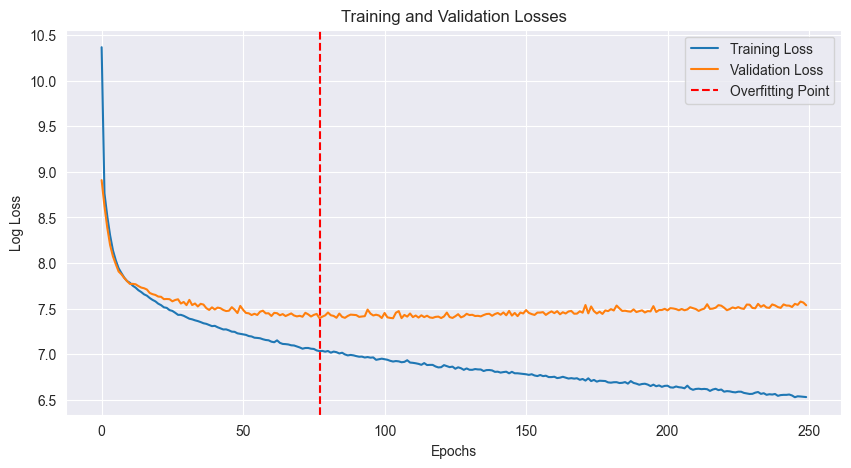

In [1219]:
X_train_tensor = X_train.astype({col: 'float32' for col in X_train.select_dtypes('bool').columns})
X_test_tensor = X_test.astype({col: 'float32' for col in X_test.select_dtypes('bool').columns})
y_train_tensor = y_train.values
y_test_tensor = y_test.values

scaler = StandardScaler()
X_train_tensor = scaler.fit_transform(X_train_tensor)
X_test_tensor = scaler.transform(X_test_tensor)

X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tensor, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_tensor, dtype=torch.float32).view(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  
        self.fc2 = nn.Linear(64, 32)         
        self.fc3 = nn.Linear(32, 16)        
        self.fc4 = nn.Linear(16, 1)          

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  
        return x

input_dim = X_train_tensor.shape[1]
model = RegressionModel(input_dim)

criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 77
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()  
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  
        predictions = model(X_batch)  
        loss = criterion(predictions, y_batch)  
        loss.backward()  
        optimizer.step()  

        epoch_loss += loss.item()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(np.log(train_loss))

    model.eval()  
    with torch.no_grad():
        val_predictions = model(X_val)  
        val_loss = criterion(val_predictions, y_val)  
        val_losses.append(np.log(val_loss.item()))

    tqdm.write(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_score = np.sqrt(criterion(y_pred, y_test_tensor).item())
    y_pred = y_pred.numpy()
    print(f'Test RMSE: {test_score:.4f}')

# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.title('Training and Validation Losses')
# plt.xlabel('Epochs')
# plt.ylabel('Log Loss')
# print(f"Best Epoch Count {np.argmin(val_losses)}")
# plt.axvline(x=np.argmin(val_losses), color='red', linestyle='--', label='Overfitting Point')  # Example overfitting point
# plt.legend()
# plt.grid(True)
# plt.savefig('Training_validation_losses.png')
# plt.show()

In [1126]:
y_pred = y_pred.flatten()

In [1127]:
r2_score_nn = r2_score(y_test, y_pred)
rmse_score_nn = rmse(y_test, y_pred)

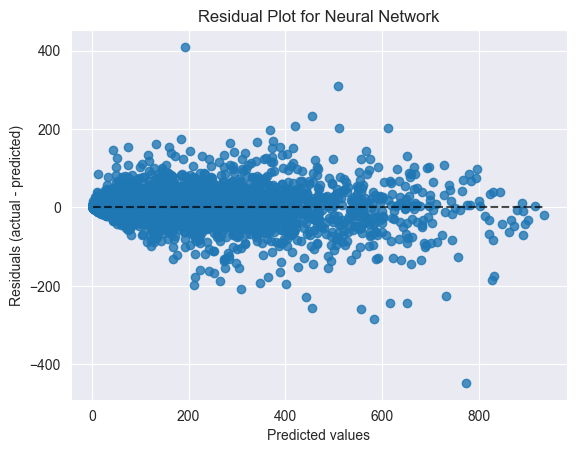

In [1128]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()
plt.title("Residual Plot for Neural Network")
# plt.savefig("residual_plot_nn.png")
plt.show()

In [1129]:
models_performance = {}

linear_regression = {"R2 Score": r2_score_lr, "MSE": rmse_score_lr}
regular_linear_regression = {"R2 Score": r2_score_lasso, "MSE": rmse_score_lasso}
svm = {"R2 Score": r2_score_svm, "MSE": rmse_score_svm}
random_forest = {"R2 Score": r2_score_rf, "MSE": rmse_score_rf}
neural_network = {"R2 Score": r2_score_nn, "MSE": rmse_score_nn}


models_performance["Linear Regression"] = linear_regression
models_performance["Regularized Linear Regression"] = regular_linear_regression
models_performance["SVM"] = svm
models_performance["Random Forest"] = random_forest
models_performance["Neural Network"] = neural_network

In [1130]:
print(models_performance)

{'Linear Regression': {'R2 Score': 0.6775547604016595, 'MSE': np.float64(102.28339134384774)}, 'Regularized Linear Regression': {'R2 Score': 0.6776962174002966, 'MSE': np.float64(102.26095297760916)}, 'SVM': {'R2 Score': 0.6952832884065757, 'MSE': np.float64(99.43179299166573)}, 'Random Forest': {'R2 Score': 0.9295261538155994, 'MSE': np.float64(47.81796849036329)}, 'Neural Network': {'R2 Score': 0.9407569766044617, 'MSE': np.float64(43.84253440270296)}}


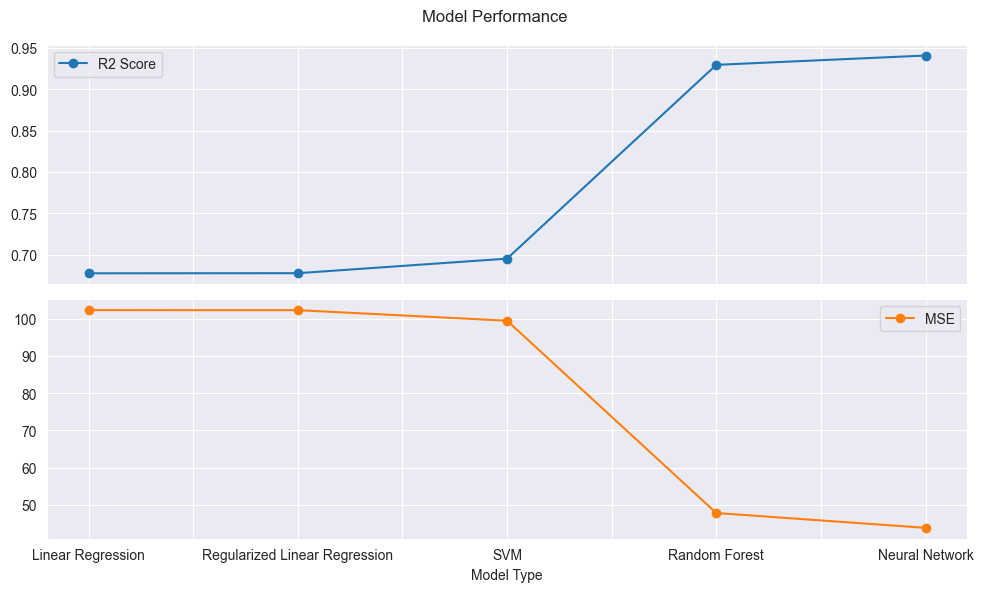

In [1131]:
df = pd.DataFrame(models_performance).T

ax = df.plot(kind="line", figsize=(10, 6), subplots=True, title = "Model Performance", grid=True, xlabel='Model Type', marker='o')

plt.xticks(rotation=0)
plt.tight_layout()
# plt.savefig("model_performance.png")
plt.show()